In [197]:
import pandas as pd
import seaborn as sns
import scipy.stats as st
import scipy
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os
from scipy.optimize import fsolve
import math
import random

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import networkx as nx

!pip install pgmpy
from pgmpy.estimators import HillClimbSearch, TreeSearch, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling

pd.set_option('precision', 5)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



Dataset name: London bike sharing dataset

Dataset source: https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

Content:

*   "timestamp" - timestamp field for grouping the data 
*   "cnt" - the count of a new bike shares
*   "t1" - real temperature in C
*   "t2" - temperature in C "feels like"
*   "hum" - humidity in percentage
*   "windspeed" - wind speed in km/h
*   "weathercode" - category of the weather
*   "isholiday" - boolean field - 1 holiday / 0 non holiday
*   "isweekend" - boolean field - 1 if the day is weekend
*   "season" - category field meteorological seasons:   0-spring ; 1-summer; 2-fall; 3-winter.
*   "weathe_code" category description:
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall 94 = Freezing Fog

**1.   Substantiation of chosen sampling**

In [147]:
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/M&M/london_merged.csv", parse_dates=["timestamp"], index_col="timestamp")
df.head(10)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.00000,2.00000,93.00000,6.00000,3.00000,0.00000,1.00000,3.00000
2015-01-04 01:00:00,138,3.00000,2.50000,93.00000,5.00000,1.00000,0.00000,1.00000,3.00000
2015-01-04 02:00:00,134,2.50000,2.50000,96.50000,0.00000,1.00000,0.00000,1.00000,3.00000
2015-01-04 03:00:00,72,2.00000,2.00000,100.00000,0.00000,1.00000,0.00000,1.00000,3.00000
2015-01-04 04:00:00,47,2.00000,0.00000,93.00000,6.50000,1.00000,0.00000,1.00000,3.00000
2015-01-04 05:00:00,46,2.00000,2.00000,93.00000,4.00000,1.00000,0.00000,1.00000,3.00000
2015-01-04 06:00:00,51,1.00000,-1.00000,100.00000,7.00000,4.00000,0.00000,1.00000,3.00000
2015-01-04 07:00:00,75,1.00000,-1.00000,100.00000,7.00000,4.00000,0.00000,1.00000,3.00000
2015-01-04 08:00:00,131,1.50000,-1.00000,96.50000,8.00000,4.00000,0.00000,1.00000,3.00000


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   t2            17414 non-null  float64
 3   hum           17414 non-null  float64
 4   wind_speed    17414 non-null  float64
 5   weather_code  17414 non-null  float64
 6   is_holiday    17414 non-null  float64
 7   is_weekend    17414 non-null  float64
 8   season        17414 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB


In [149]:
df = df.loc[(df.index.hour == 8)]

df = df.loc[(df['is_weekend'] == 0)]

df = df[['cnt', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'season']]

In [150]:
df.head(10)

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,season
timestamp,,,,,,,,
2015-01-05 08:00:00,3161,8.00000,7.50000,79.00000,5.00000,3.00000,0.00000,3.00000
2015-01-06 08:00:00,3534,9.00000,7.00000,82.00000,12.00000,7.00000,0.00000,3.00000
2015-01-07 08:00:00,3618,6.50000,3.50000,81.00000,15.00000,2.00000,0.00000,3.00000
2015-01-08 08:00:00,1228,9.50000,7.50000,87.50000,14.00000,7.00000,0.00000,3.00000
2015-01-09 08:00:00,3505,12.00000,12.00000,79.50000,25.00000,2.00000,0.00000,3.00000
2015-01-12 08:00:00,3418,10.00000,6.00000,76.00000,31.00000,3.00000,0.00000,3.00000
2015-01-13 08:00:00,3960,9.00000,6.50000,71.00000,16.00000,2.00000,0.00000,3.00000
2015-01-14 08:00:00,3904,4.00000,-1.00000,70.00000,26.00000,2.00000,0.00000,3.00000
2015-01-15 08:00:00,3673,9.00000,6.00000,66.00000,21.00000,1.00000,0.00000,3.00000


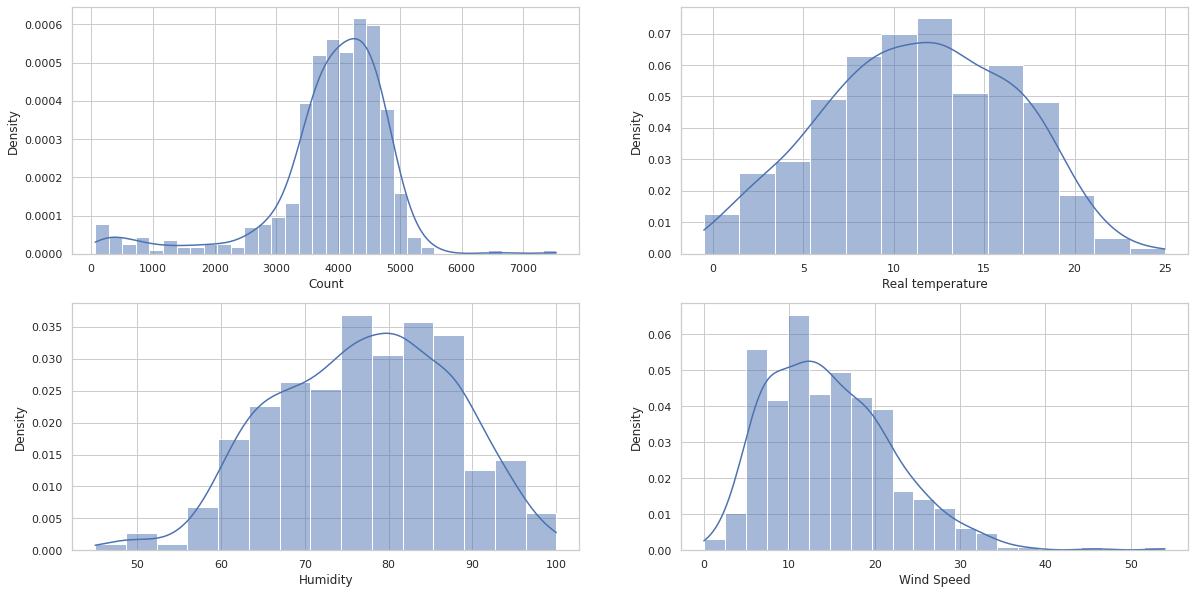

In [182]:
figure, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.set_theme(style='whitegrid')

cnt = sns.histplot(df.cnt, ax=ax[0, 0], kde=True, stat='density')
cnt.set(xlabel='Count')

t1 = sns.histplot(df.t1, ax=ax[0, 1], kde=True, stat='density')
t1.set(xlabel='Real temperature')

hum = sns.histplot(df.hum, ax=ax[1, 0], kde=True, stat='density')
hum.set(xlabel='Humidity')

wind_speed = sns.histplot(df.wind_speed, ax=ax[1, 1], kde=True, stat='density')
wind_speed.set(xlabel='Wind Speed')

plt.show()

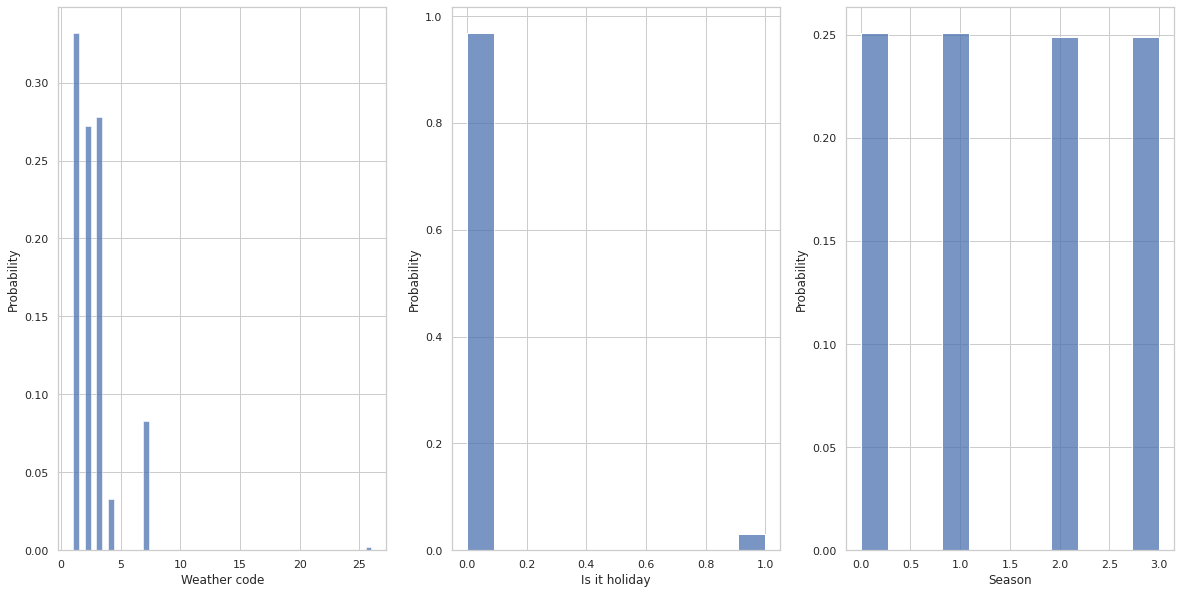

In [179]:
figure, ax = plt.subplots(1, 3, figsize=(20, 10))
sns.set_theme(style='whitegrid')

weather_code = sns.histplot(df.weather_code, ax=ax[0], kde=False, stat='probability')
weather_code.set(xlabel='Weather code')

is_holiday = sns.histplot(df.is_holiday, ax=ax[1], kde=False, stat='probability')
is_holiday.set(xlabel='Is it holiday')

season = sns.histplot(df.season, ax=ax[2], kde=False, stat='probability')
season.set(xlabel='Season')

plt.show()

**2.   Sampling of Chosen Target Variables Using Univariate Parametric Distributions with 2 Different Sampling Methods**

In [154]:
def inverse_transform_sampling(array, distribution):

    args = distribution.fit(array)
    data = np.random.uniform(size=len(array))
    sample = distribution(*args)
    sample= sample.ppf(data)
    
    return sample

def random_sampling(array, distribution):

    args = distribution.fit(array)
    sample = distribution.rvs(*args, size=len(array))

    return sample

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


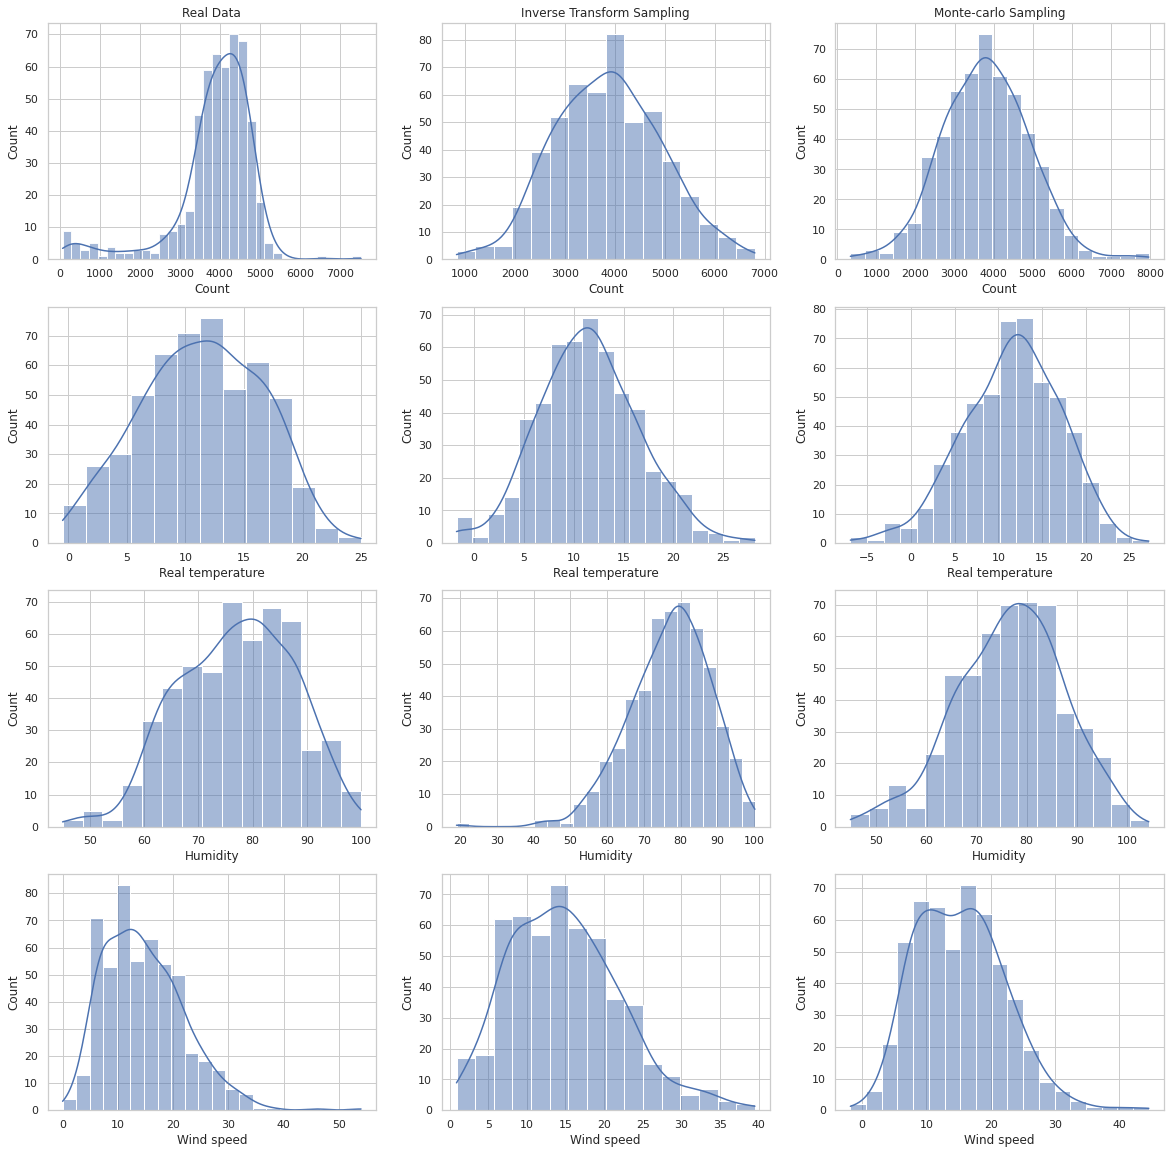

In [184]:
figure, ax = plt.subplots(4, 3, figsize=(20, 20))
sns.set_theme(style='whitegrid')

sns.histplot(df.cnt, ax=ax[0, 0], kde=True)
sns.histplot(inverse_transform_sampling(df.cnt, distribution=scipy.stats.gamma), ax=ax[0, 1], kde=True)
sns.histplot(random_sampling(df.cnt, distribution=scipy.stats.gamma), ax=ax[0, 2], kde=True)

sns.histplot(df.t1, ax=ax[1, 0], kde=True)
sns.histplot(inverse_transform_sampling(df.t1, distribution=scipy.stats.loggamma), ax=ax[1, 1], kde=True)
sns.histplot(random_sampling(df.t1, distribution=scipy.stats.loggamma), ax=ax[1, 2], kde=True)

sns.histplot(df.hum, ax=ax[2, 0], kde=True)
sns.histplot(inverse_transform_sampling(df.hum, distribution=scipy.stats.loggamma), ax=ax[2, 1], kde=True)
sns.histplot(random_sampling(df.hum, distribution=scipy.stats.loggamma), ax=ax[2, 2], kde=True)

sns.histplot(df.wind_speed, ax=ax[3, 0], kde=True)
sns.histplot(inverse_transform_sampling(df.wind_speed, distribution=scipy.stats.beta), ax=ax[3, 1], kde=True)
sns.histplot(random_sampling(df.wind_speed, distribution=scipy.stats.beta), ax=ax[3, 2], kde=True)

ax[0, 0].set_title('Real Data')
ax[0, 1].set_title('Inverse Transform Sampling')
ax[0, 2].set_title('Monte-carlo Sampling')

ax[0, 0].set(xlabel='Count')
ax[0, 1].set(xlabel='Count')
ax[0, 2].set(xlabel='Count')
ax[1, 0].set(xlabel='Real temperature')
ax[1, 1].set(xlabel='Real temperature')
ax[1, 2].set(xlabel='Real temperature')
ax[2, 0].set(xlabel='Humidity')
ax[2, 1].set(xlabel='Humidity')
ax[2, 2].set(xlabel='Humidity')
ax[3, 0].set(xlabel='Wind speed')
ax[3, 1].set(xlabel='Wind speed')
ax[3, 2].set(xlabel='Wind speed')

plt.show()

In [156]:
df_its = pd.DataFrame(data={
    'cnt': inverse_transform_sampling(df.cnt, distribution=scipy.stats.gamma),
    't1': inverse_transform_sampling(df.t1, distribution=scipy.stats.loggamma),
    'hum': inverse_transform_sampling(df.hum, distribution=scipy.stats.loggamma),
    'wind_speed': inverse_transform_sampling(df.wind_speed, distribution=scipy.stats.beta),
    'weather_code': df.weather_code,
    'is_holiday': df.is_holiday,
    'season': df.season
})

df_its.head(10)

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


,cnt,t1,hum,wind_speed,weather_code,is_holiday,season
timestamp,,,,,,,
2015-01-05 08:00:00,2716.68549,6.31141,81.49315,17.98745,3.00000,0.00000,3.00000
2015-01-06 08:00:00,5503.23671,9.35667,74.28857,23.87493,7.00000,0.00000,3.00000
2015-01-07 08:00:00,3887.06112,17.18173,56.08350,11.76511,2.00000,0.00000,3.00000
2015-01-08 08:00:00,2724.26877,5.46869,80.51948,27.68669,7.00000,0.00000,3.00000
2015-01-09 08:00:00,4760.54362,6.01910,61.10795,14.20676,2.00000,0.00000,3.00000
2015-01-12 08:00:00,6460.59461,14.52279,94.69303,16.54018,3.00000,0.00000,3.00000
2015-01-13 08:00:00,3413.87261,12.84476,64.46079,15.07451,2.00000,0.00000,3.00000
2015-01-14 08:00:00,4156.68135,13.61865,71.44284,24.95763,2.00000,0.00000,3.00000
2015-01-15 08:00:00,4747.34943,8.85708,91.30352,17.11649,1.00000,0.00000,3.00000


In [157]:
df_its[['cnt', 't1', 'hum', 'wind_speed']].mean()

cnt          3845.58155
t1             11.48810
hum            76.79532
wind_speed     14.61687
dtype: float64

In [158]:
df_its[['cnt', 't1', 'hum', 'wind_speed']].var()

cnt          1175004.71539
t1                25.84199
hum              118.75932
wind_speed        50.27930
dtype: float64

In [159]:
df_rand = pd.DataFrame(data={
    'cnt': custom_sampling(df.cnt, distribution=scipy.stats.gamma),
    't1': custom_sampling(df.t1, distribution=scipy.stats.loggamma),
    'hum': custom_sampling(df.hum, distribution=scipy.stats.loggamma),
    'wind_speed': custom_sampling(df.wind_speed, distribution=scipy.stats.beta),
    'weather_code': df.weather_code,
    'is_holiday': df.is_holiday,
    'season': df.season
})

df_cust.head(10)

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


,cnt,t1,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,
2015-01-04 08:00:00,47.19448,9.06067,86.01289,27.64280,4.00000,0.00000,1.00000,3.00000
2015-01-05 08:00:00,5332.81250,9.64125,73.40601,12.65718,3.00000,0.00000,0.00000,3.00000
2015-01-06 08:00:00,4828.76867,6.22663,61.14927,14.22092,7.00000,0.00000,0.00000,3.00000
2015-01-07 08:00:00,5778.89021,16.21916,90.64651,19.43130,2.00000,0.00000,0.00000,3.00000
2015-01-08 08:00:00,2160.48088,10.31826,64.36849,12.47609,7.00000,0.00000,0.00000,3.00000
2015-01-09 08:00:00,4600.03241,16.81993,65.80725,3.63100,2.00000,0.00000,0.00000,3.00000
2015-01-10 08:00:00,2348.45099,4.57804,56.69924,16.00424,3.00000,0.00000,1.00000,3.00000
2015-01-11 08:00:00,892.42315,15.88026,84.07464,24.90050,1.00000,0.00000,1.00000,3.00000
2015-01-12 08:00:00,4266.58946,8.02717,86.88039,25.32584,3.00000,0.00000,0.00000,3.00000


In [160]:
df_cust[['cnt', 't1', 'hum', 'wind_speed']].mean()

cnt          2898.86080
t1             11.68104
hum            77.04616
wind_speed     14.74394
dtype: float64

In [161]:
df_cust[['cnt', 't1', 'hum', 'wind_speed']].var()

cnt          3103292.17166
t1                24.13769
hum              110.03958
wind_speed        53.69227
dtype: float64

In [162]:
def return_biplot(array, distribution, ax):
    args = distribution.fit(array)
    scipy.stats.probplot(array, dist=distribution, sparams=(args), plot=ax)
    ax.get_lines()[0].set_marker('o')
    ax.get_lines()[1].set_ls('--')
    ax.get_lines()[1].set_color('black')
    ax.get_lines()[1].set_linewidth(0.5)

/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:547: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  wa

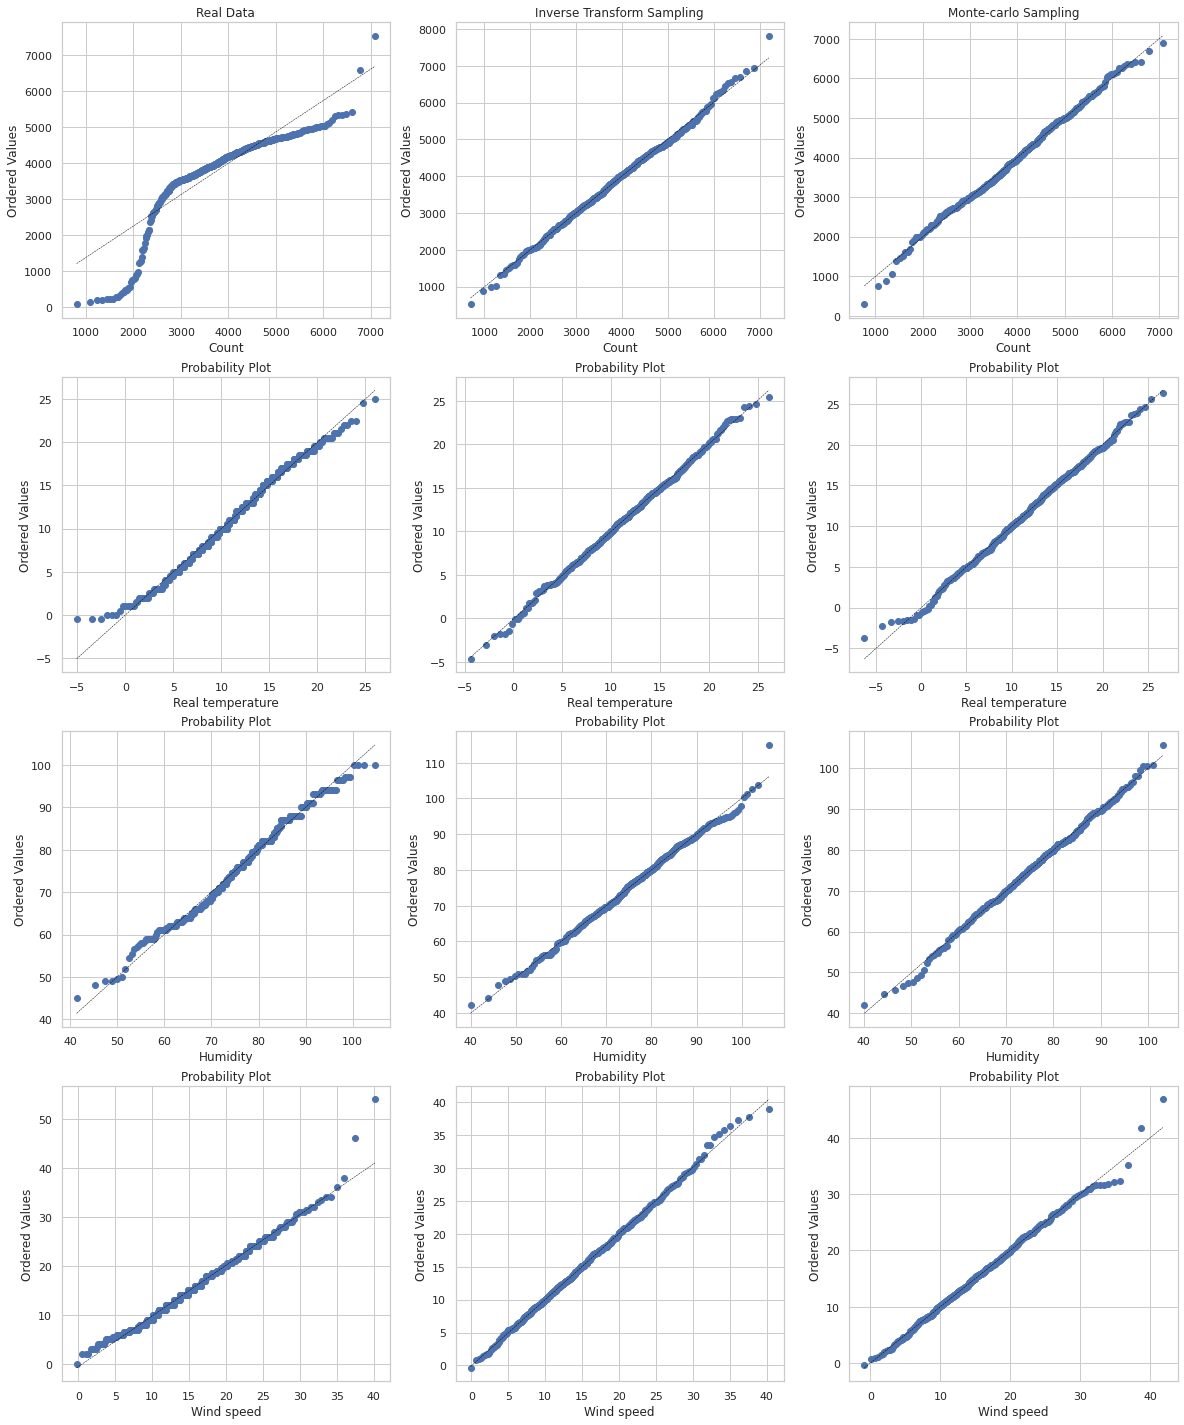

In [183]:
figure, ax = plt.subplots(4, 3, figsize=(20, 25))
sns.set_theme(style='whitegrid')

return_biplot(df.cnt, distribution=scipy.stats.gamma, ax=ax[0, 0])
return_biplot(df_its.cnt, distribution=scipy.stats.gamma, ax=ax[0, 1])
return_biplot(df_rand.cnt, distribution=scipy.stats.gamma, ax=ax[0, 2])

return_biplot(df.t1, distribution=scipy.stats.loggamma, ax=ax[1, 0])
return_biplot(df_its.t1, distribution=scipy.stats.loggamma, ax=ax[1, 1])
return_biplot(df_rand.t1, distribution=scipy.stats.loggamma, ax=ax[1, 2])

return_biplot(df.hum, distribution=scipy.stats.loggamma, ax=ax[2, 0])
return_biplot(df_its.hum, distribution=scipy.stats.loggamma, ax=ax[2, 1])
return_biplot(df_rand.hum, distribution=scipy.stats.loggamma, ax=ax[2, 2])

return_biplot(df.wind_speed, distribution=scipy.stats.beta, ax=ax[3, 0])
return_biplot(df_its.wind_speed, distribution=scipy.stats.beta, ax=ax[3, 1])
return_biplot(df_rand.wind_speed, distribution=scipy.stats.beta, ax=ax[3, 2])

ax[0, 0].set_title('Real Data')
ax[0, 1].set_title('Inverse Transform Sampling')
ax[0, 2].set_title('Monte-carlo Sampling')

ax[0, 0].set(xlabel='Count')
ax[0, 1].set(xlabel='Count')
ax[0, 2].set(xlabel='Count')
ax[1, 0].set(xlabel='Real temperature')
ax[1, 1].set(xlabel='Real temperature')
ax[1, 2].set(xlabel='Real temperature')
ax[2, 0].set(xlabel='Humidity')
ax[2, 1].set(xlabel='Humidity')
ax[2, 2].set(xlabel='Humidity')
ax[3, 0].set(xlabel='Wind speed')
ax[3, 1].set(xlabel='Wind speed')
ax[3, 2].set(xlabel='Wind speed')

plt.show()

**3.   Estimation of Relations Between Predictors and Chosen Target Variables**

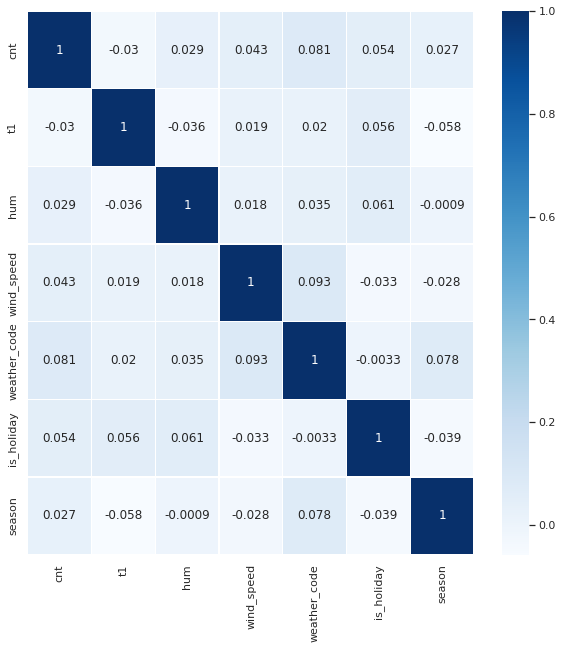

In [185]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.set_theme(style='whitegrid')

sns.heatmap(df_its[['cnt', 't1', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'season']].corr(), cmap='Blues', annot=True, linewidths=0.25)

plt.show()

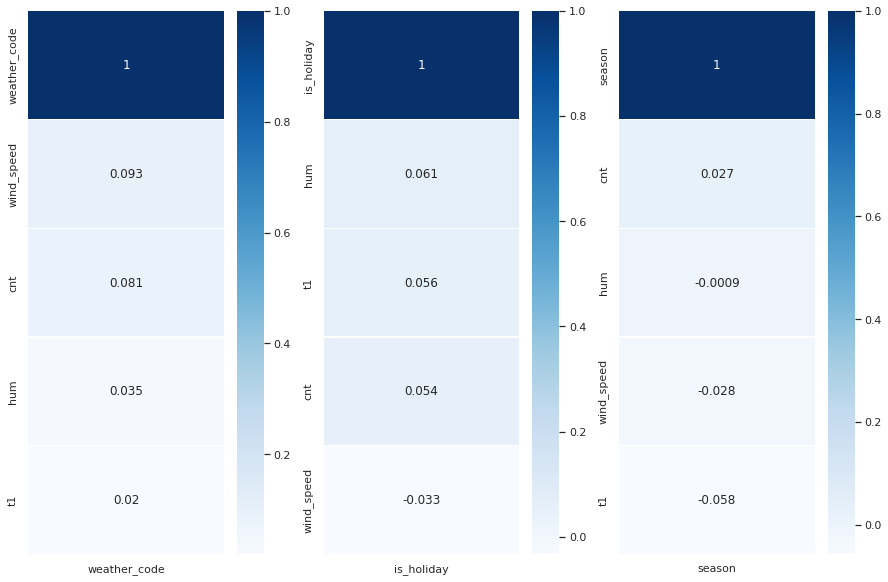

In [190]:
figure, ax = plt.subplots(1, 3, figsize=(15, 10))
sns.set_theme(style='whitegrid')

sns.heatmap(
    df_its[['cnt', 't1', 'hum', 'wind_speed', 'weather_code']].corr()[['weather_code']].sort_values(by='weather_code', ascending=False),
    cmap='Blues',
    annot=True,
    linewidths=0.25,
    ax=ax[0]
)

sns.heatmap(
    df_its[['cnt', 't1', 'hum', 'wind_speed', 'is_holiday']].corr()[['is_holiday']].sort_values(by='is_holiday', ascending=False),
    cmap='Blues',
    annot=True,
    linewidths=0.25,
    ax=ax[1]
)

sns.heatmap(
    df_its[['cnt', 't1', 'hum', 'wind_speed', 'season']].corr()[['season']].sort_values(by='season', ascending=False),
    cmap='Blues',
    annot=True,
    linewidths=0.25,
    ax=ax[2]
)

plt.show()

**4.   Bayesian Network**

In [220]:
df_transformed = df_its.copy()
discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans')
df_discretized = discretizer.fit_transform(df_its.values[:, [0, 1, 2, 3]])
df_transformed[['cnt', 't1', 'hum', 'wind_speed']] = df_discretized
df_transformed.head(10)

,cnt,t1,hum,wind_speed,weather_code,is_holiday,season
timestamp,,,,,,,
2015-01-05 08:00:00,0.00000,0.00000,1.00000,1.00000,3.00000,0.00000,3.00000
2015-01-06 08:00:00,1.00000,0.00000,0.00000,1.00000,7.00000,0.00000,3.00000
2015-01-07 08:00:00,1.00000,1.00000,0.00000,0.00000,2.00000,0.00000,3.00000
2015-01-08 08:00:00,0.00000,0.00000,1.00000,1.00000,7.00000,0.00000,3.00000
2015-01-09 08:00:00,1.00000,0.00000,0.00000,0.00000,2.00000,0.00000,3.00000
2015-01-12 08:00:00,1.00000,1.00000,1.00000,1.00000,3.00000,0.00000,3.00000
2015-01-13 08:00:00,0.00000,1.00000,0.00000,0.00000,2.00000,0.00000,3.00000
2015-01-14 08:00:00,1.00000,1.00000,0.00000,1.00000,2.00000,0.00000,3.00000
2015-01-15 08:00:00,1.00000,0.00000,1.00000,1.00000,1.00000,0.00000,3.00000


In [216]:
edges_list = [
    ('wind_speed', 'weather_code'),
    ('wind_speed', 'cnt'),
    ('weather_code', 'cnt'),
    ('season', 'weather_code'),
    ('t1', 'is_holiday'),
    ('is_holiday', 'cnt')
]

pred_model = BayesianModel(edges_list)

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNewtork class, BayesianModel will be removed in future.
  FutureWarning,


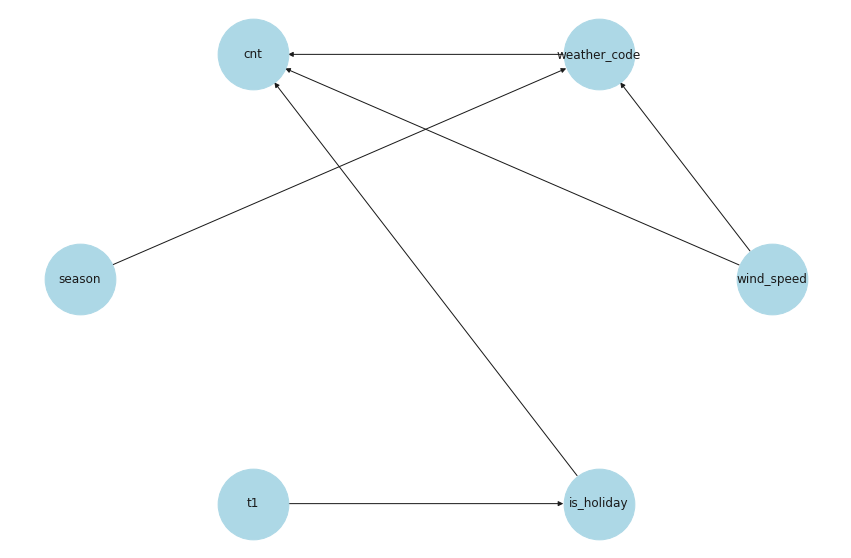

In [217]:
figure, ax = plt.subplots(1, 1, figsize=(15, 10))

graph = nx.DiGraph()
graph.add_edges_from(pred_model.edges())

positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightblue', node_size=5000)

plt.show()

In [221]:
hc_search = HillClimbSearch(data = df_transformed)
hc_k2 = hc_search.estimate(scoring_method=K2Score(df_transformed))
hc_bic = hc_search.estimate(scoring_method=BicScore(df_transformed))

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

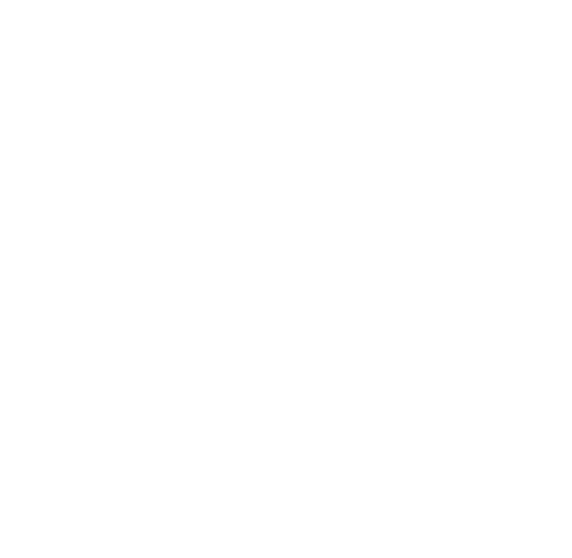

In [208]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(hc_bic.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightskyblue', node_size=5000)

plt.show()

In [204]:
e_search = TreeSearch(data=df_transformed)
e_model = e_search.estimate()

Building tree:   0%|          | 0/21.0 [00:00<?, ?it/s]

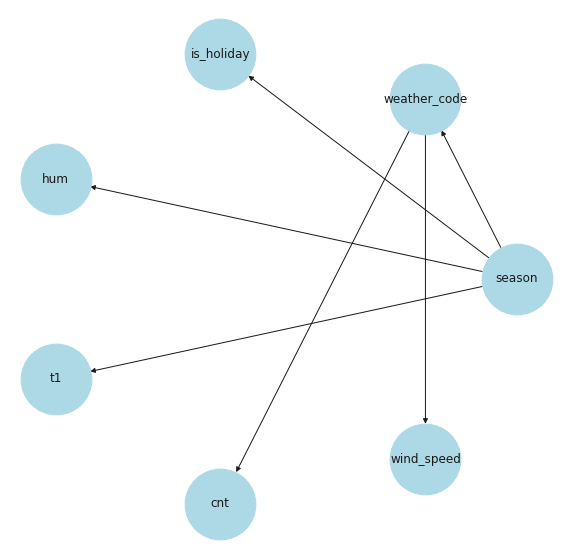

In [218]:
figure, ax = plt.subplots(1, 1, figsize=(10, 10))

graph = nx.DiGraph()
graph.add_edges_from(e_model.edges())
positions = nx.layout.circular_layout(graph)
nx.draw(graph, positions, with_labels=True, node_color='lightblue', node_size=5000)

plt.show()